## PyTorch Workflow.

Let's explore the pytorch end-to-end workflow

In [ ]:
what_were_covering = {1: "data (prepare and load)",
                       2:  "build model",
                       3:  "fitting the model to data (training)",
                       4:  "making predictions and evaluating a model (inference)",
                       5:  "saving and loading a model",
                       6:  "putting it all together"}
what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [ ]:
import torch
from torch import nn # nn contains all of PyTocrh's building blocks for nueral networks
import matplotlib.pyplot as plt

# Check PyTorch Version
torch.__version__

'2.0.1+cu118'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of any kind
* Videos (Youtube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into numerical representation.
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some *known* data using the linear regression formula.

We'll use a linear regression formula to make a straight line with known parameters.

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create some data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

In [ ]:
def plot_predictions(train_data = X_train, train_labels = y_train, test_data = X_test, test_labels = y_test, predictions = None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize = (10,7))

  #Plot training data in blue
  plt.scatter(train_data, train_labels, c = "b", s = 4, label = 'Training data')

  #Plot test data in green
  plt.scatter(test_data, test_labels, c = "g", s = 4, label = "Testing data")

  #Are there any predictions?
  if predictions is not None:
    #Plot the predictions if they exist
    plt.scatter(test_data, predictions, c = "r", label = "Predictions")

  #Show the legend
  plt.legend(prop = {'size': 14})

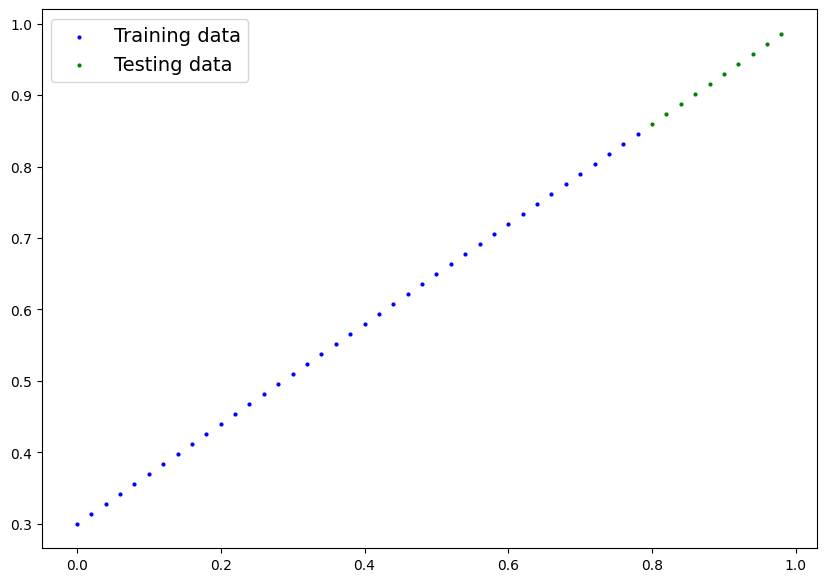

In [ ]:
plot_predictions()

# Build Model

Our first PyTorch model!

This is very exciting... let's do it!

What our model does:
 * Start with random values (weight & bias)
 * Look at the training data and adjust the random values to better represent (or get closer to) ideal values (the weight & bias values we used to create the data)

 How does it do so?

 Through two main algorithms:
 1. Gradient descent
 2. Backpropagation

In [ ]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad = True, dtype = torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad = True, dtype = torch.float))

  # Forward Prop to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- x is the input data
    return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* torch.nn - contains all the building blocks for computational graphs (A nueral network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyToch layer from torch.nn will set for us.
* torch.nn.Module - The base class for all nueral networks modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent.
* def forward() - All nn.Modules subclasses require you to overwrite forward(), this method defines what happens in the forward computation.

### Checking the contents of our PyTorch model

So, we can check our model parameters or what's inside our model using .parameters()


In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `x_test`.

When we pass data through our model, it's going to run it through the forward method.

In [ ]:
# make predictions with model
with torch.inference_mode(): # Turns off gradient tracking
  y_preds = model_0(X_test)

# with torch.no_grad(): # Something similar to inference_mode but inference_mode is more preferred.
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

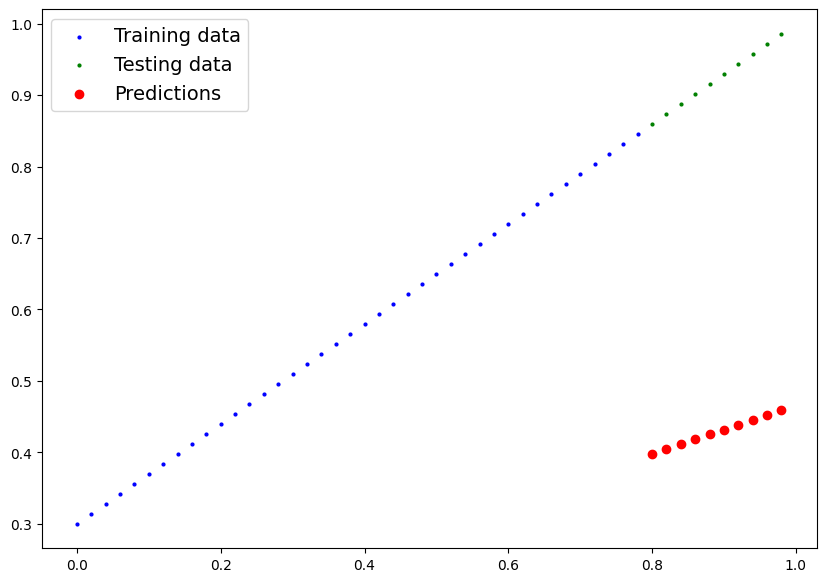

In [ ]:
plot_predictions(predictions=y_preds)

 ## Train Model

 The whole idea of training for a model is to move from some *unknown* parameters (these may be random) to some *known* parameters.

 Or in other words from a poor representation of the data to a better representation of the data.

 One way to measure how poor or how wrong your models predictions are is to use a loss function.

 * Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

 Things we need to train:

 * **Loss function:** A function to meansure how wrong your model's predictions are to the ideal output. Lower is better.
 * **Optimizer:** Takes into account the loss of the model and adjusts the model's parameters (e.g: weights and bias in our case) to improve the loss function.

 And specifically for PyTorch, we need:
  * A training loop.
  * A testing loop.

In [ ]:
# Check out our model's parameters (a parameter is a value that the model sets itself)
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01 # lr = learning rate -> Possibly the most important hyperparameter you want to set.
                            )

**Q:** Which loss function and optimizer should I use?

**A:** This is problem specific but with experience, you'll get an idea of what works and what doesn't with your problem set.
For Example: A regression problem like ours, a loss function like nn.Loss and an optimizer like  and an optimizer like
`torch.optim.SGD()` will suffice.
But for classification problems like classifying a photo of a dog or a cat, you'll likely to use the loss function of
`nn.BCELoss()` (Binary Cross Entropy).

## Building a training loop (and a testing loop) in Pytorch

A couple of things we need in a training loop:
0. Loop throuh the data
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propogation.
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - moves backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss. (`backpropagation`)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (`gradient descent`)

In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data... (Hyperparameter)
epochs = 200

# Tracking different values
epoch_count = []
loss_values = []
test_loss_values = []


### Training
# Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in pytorch sets all parameters that require gardients to require gardients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Oprtimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by defualt how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 iteration through the loop.

  ## Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batchnorm)
  with torch.inference_mode(): #turns off gradient tracking & a couple more things behind the scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loos
    test_loss = loss_fn(test_pred, y_test)

  # Print what's going on
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

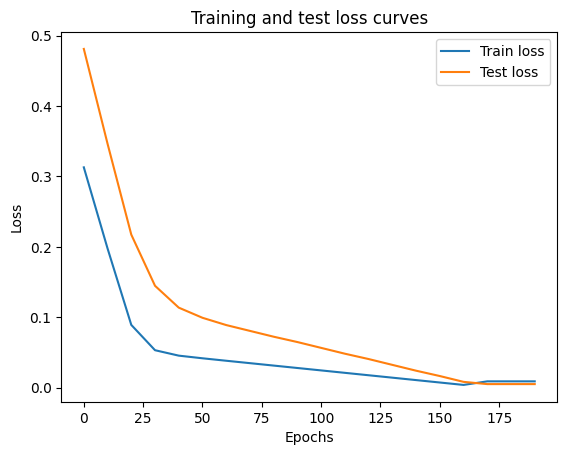

In [ ]:
# Plot the loss curves
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title('Training and test loss curves')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

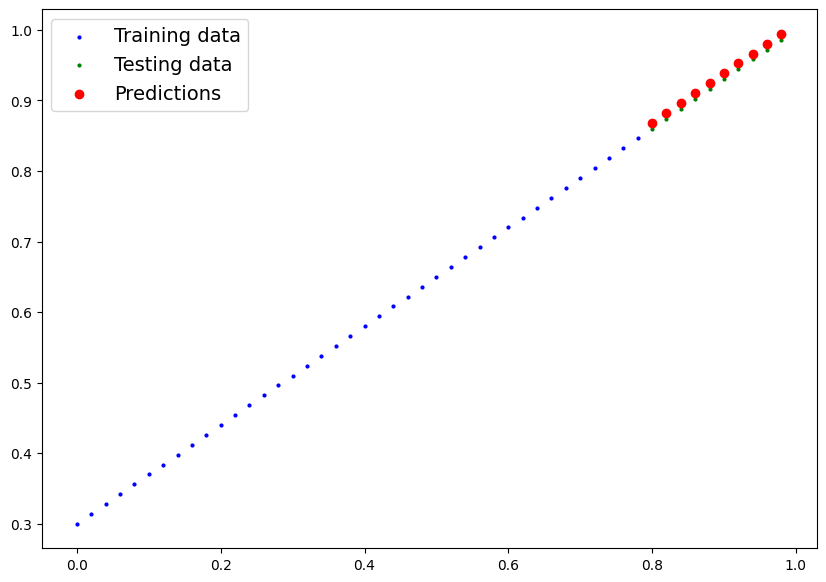

In [ ]:
plot_predictions(predictions = y_preds_new)

## Saving a model in PyTorch

There are three main methods for saving and loading the models in PyTorch.

1. `torch.save():` This allows you to save the model in Python's pickle format.
2. `torch.load():` Allows you to load a saved PyTorch object.
3. `torch.nn.Module.load_state_dict():` This allows you to load a model's saved state dictionary.

In [ ]:
# Saving our Pytorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()`, rather than the entire model, we'll create a new instance of our model class and load the `state_dict()` into that.

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Make some models preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

In [ ]:
# Compare loaded model preds with orignial preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see them all in one place.

In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.0.1+cu118'

## Create device agnostic code

This means if we've got access to a GPU, our code will use it (for potentially faster computing).

If no GPU is available the code will default to using CPU.

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## 6.1 Data

In [ ]:
# Create some data using the linear regression formula of y = weight * x + bias
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

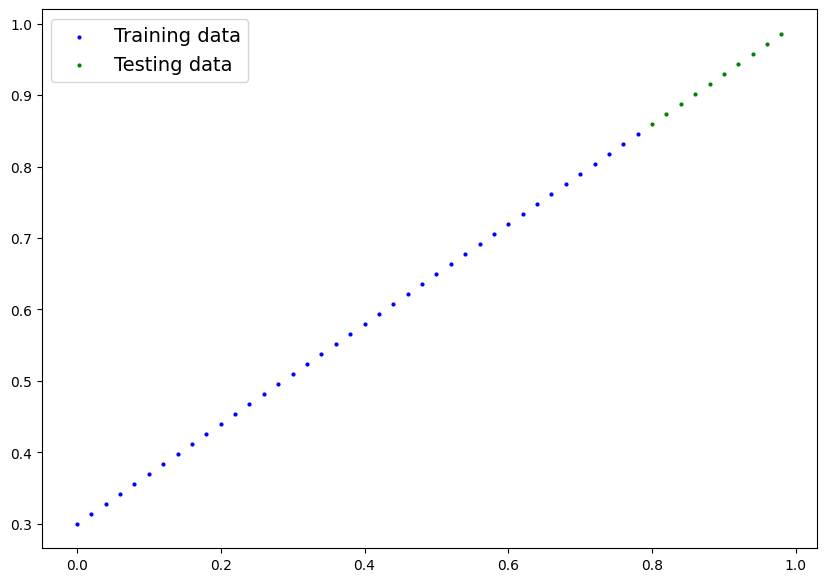

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

## 6.2 Building a PyTorch Linear Model

In [ ]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer in tensor flow.
    self.linear_layer = nn.Linear(in_features = 1, out_features = 1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

## 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training Loop
* Testing Loop

In [ ]:
# Setup the loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.01)

In [ ]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (Device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer Step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_preds = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test Loss: 0.008447891101241112
Epoch: 10 | Loss: 0.4399680495262146 | Test Loss: 0.008447891101241112
Epoch: 20 | Loss: 0.3247582018375397 | Test Loss: 0.008447891101241112
Epoch: 30 | Loss: 0.20954827964305878 | Test Loss: 0.008447891101241112
Epoch: 40 | Loss: 0.09433844685554504 | Test Loss: 0.008447891101241112
Epoch: 50 | Loss: 0.023886386305093765 | Test Loss: 0.008447891101241112
Epoch: 60 | Loss: 0.0199567973613739 | Test Loss: 0.008447891101241112
Epoch: 70 | Loss: 0.016517987474799156 | Test Loss: 0.008447891101241112
Epoch: 80 | Loss: 0.013089170679450035 | Test Loss: 0.008447891101241112
Epoch: 90 | Loss: 0.009653178043663502 | Test Loss: 0.008447891101241112
Epoch: 100 | Loss: 0.006215679459273815 | Test Loss: 0.008447891101241112
Epoch: 110 | Loss: 0.002787243574857712 | Test Loss: 0.008447891101241112
Epoch: 120 | Loss: 0.0012645035749301314 | Test Loss: 0.008447891101241112
Epoch: 130 | Loss: 0.0012645035749301314 | Test Loss: 0.00

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [ ]:
weight, bias

(0.7, 0.3)

## 6.4 Making and evaluating predictions

In [ ]:
# Turn the model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

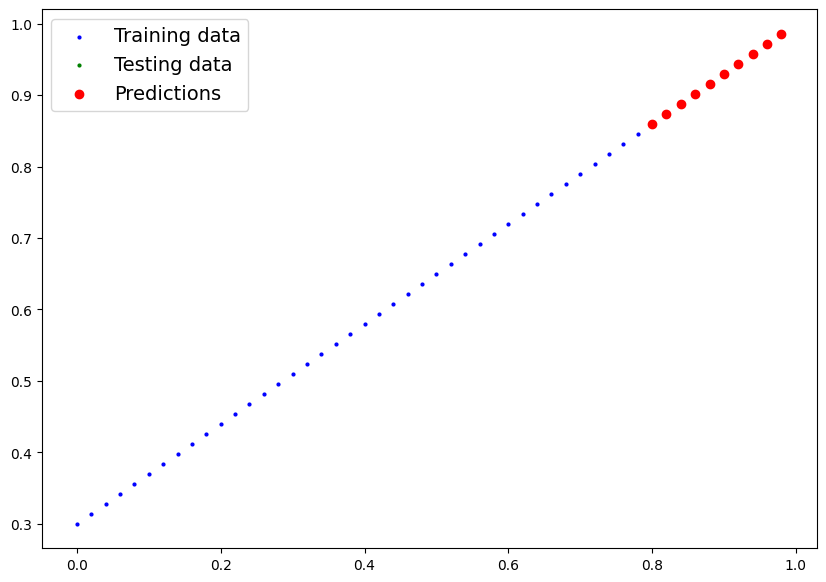

In [ ]:
# Check out our model predictions visually

plot_predictions(predictions = y_preds.cpu())

## 6.5 Saving and Loading a trained model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(), f = MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [ ]:
# Load a PyTorch Model

# Create a new instance of Linear Regression Model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to the device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])